<a href="https://colab.research.google.com/github/Stelian-DRAGNE/Predictia-categoriei-produsului-pe-baza-titlului/blob/main/Proiect/notebooks/exploration_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Category Prediction – Notebook

Explorare, antrenare și evaluare.

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("products.csv")
df.columns = [c.strip() for c in df.columns]
df = df.rename(columns={"Category Label":"Category_Label"})

# ✅ eliminăm rândurile cu NaN
df = df.dropna(subset=["Product Title", "Category_Label"]).copy()

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 35096 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35096 non-null  int64  
 1   Product Title    35096 non-null  object 
 2   Merchant ID      35096 non-null  int64  
 3   Category_Label   35096 non-null  object 
 4   _Product Code    35002 non-null  object 
 5   Number_of_Views  35082 non-null  float64
 6   Merchant Rating  34926 non-null  float64
 7   Listing Date     35038 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.4+ MB


,product ID,Product Title,Merchant ID,Category_Label,_Product Code,Number_of_Views,Merchant Rating,Listing Date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023


In [2]:

df['Category_Label'].value_counts().head(10)


,count
Category_Label,
Fridge Freezers,5470
Washing Machines,4015
Mobile Phones,4002
CPUs,3747
TVs,3541
Fridges,3436
Dishwashers,3405
Digital Cameras,2689
Microwaves,2328


In [3]:

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import pandas as pd

def feature_frame_from_titles(titles: pd.Series) -> pd.DataFrame:
    s = titles.fillna("")
    num_chars = s.str.len().astype(float)
    num_words = s.str.split().str.len().astype(float)
    has_digits = s.str.contains(r"\d").astype(int)
    has_caps_token = s.str.contains(r"\b[A-Z]{2,}\b").astype(int)
    longest_word = s.str.split().apply(lambda toks: max((len(t) for t in toks), default=0)).astype(float)
    return pd.DataFrame({
        "num_chars": num_chars,
        "num_words": num_words,
        "has_digits": has_digits,
        "has_caps_token": has_caps_token,
        "longest_word": longest_word
    })

def ft_transform(X):
    return feature_frame_from_titles(pd.Series(X))

text_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9, strip_accents="unicode")
preprocess = ColumnTransformer([
    ("tfidf", text_vectorizer, "Product Title"),
    ("num", Pipeline([("eng", FunctionTransformer(ft_transform, validate=False)), ("scale", MinMaxScaler())]), "Product Title")
])

pipe = Pipeline([("preprocess", preprocess), ("clf", LinearSVC(class_weight="balanced", random_state=42, max_iter=5000))])

X_train, X_test, y_train, y_test = train_test_split(df[["Product Title"]], df["Category_Label"], test_size=0.2, random_state=42, stratify=df["Category_Label"])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, zero_division=0))

joblib.dump(pipe, "model_product_category.pkl")


Accuracy: 0.9535612535612535
                  precision    recall  f1-score   support

             CPU       0.00      0.00      0.00        17
            CPUs       0.98      0.99      0.98       749
 Digital Cameras       1.00      1.00      1.00       538
     Dishwashers       0.98      0.93      0.96       681
        Freezers       0.91      0.96      0.94       440
 Fridge Freezers       0.96      0.95      0.96      1094
         Fridges       0.89      0.89      0.89       687
      Microwaves       0.99      0.98      0.98       466
    Mobile Phone       0.00      0.00      0.00        11
   Mobile Phones       0.98      0.99      0.98       801
             TVs       0.99      0.99      0.99       708
Washing Machines       0.97      0.95      0.96       803
          fridge       0.02      0.04      0.02        25

        accuracy                           0.95      7020
       macro avg       0.74      0.74      0.74      7020
    weighted avg       0.96      0.95    

['model_product_category.pkl']

## Confusion matrix (top 15 classes)

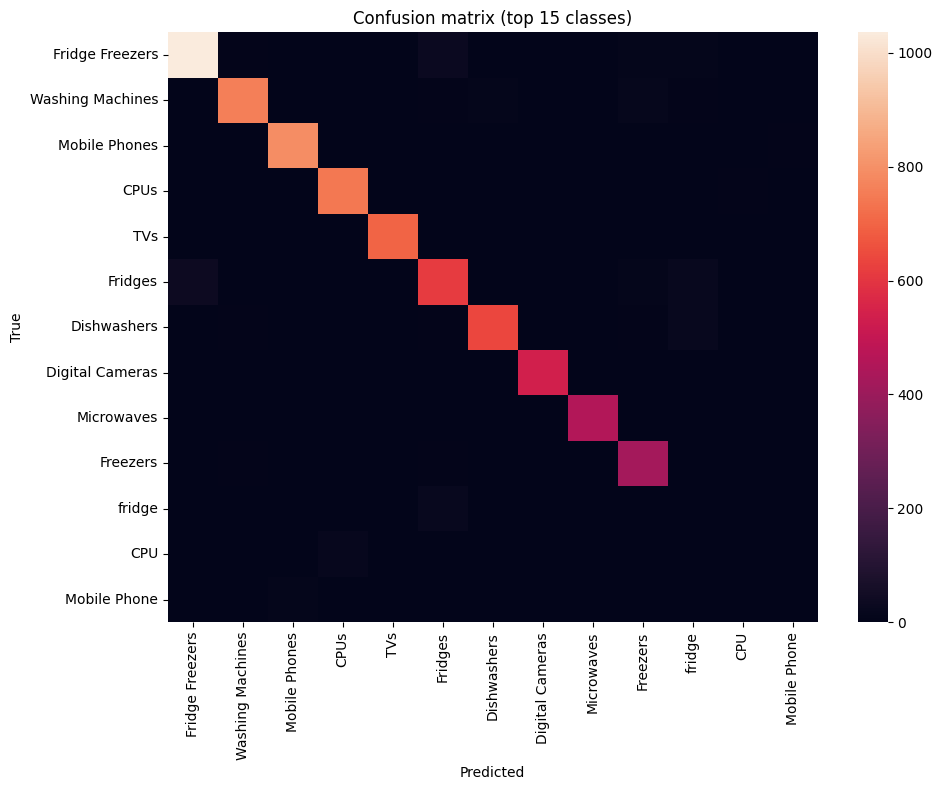

In [4]:

from collections import Counter
top_classes = [c for c,_ in Counter(y_test).most_common(15)]
mask = y_test.isin(top_classes)
cm = confusion_matrix(y_test[mask], pd.Series(pred, index=y_test.index)[mask], labels=top_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, fmt="d", xticklabels=top_classes, yticklabels=top_classes)
plt.title("Confusion matrix (top 15 classes)")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
plt.show()
